# Model profiles using different type of source redshift information as input

In this example we model profile by giving as input either : 
- discrete source redshifts, 
- a redshift distribution function,
- the value of the mean beta parameters : 
$\langle \beta_s \rangle = \left\langle \frac{D_{LS}}{D_S}\frac{D_\infty}{D_{L,\infty}}\right\rangle$ ,
$\langle \beta_s^2 \rangle = \left\langle \left(\frac{D_{LS}}{D_S}\frac{D_\infty}{D_{L,\infty}}\right)^2 \right\rangle$

In [1]:
import warnings
warnings.filterwarnings("ignore", message='.*(!).*')
import os
## Uncomment the following line if you want to use a specific modeling backend among 'ct' (cluster-toolkit), 'ccl' (CCL) or 'nc' (Numcosmo). Default is 'ccl'
#os.environ['CLMM_MODELING_BACKEND'] = 'nc'

In [2]:
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Make sure we know which version we're using

In [3]:
clmm.__version__

'1.3.4'

## Import mock data module and setup the configuration 

In [4]:
from clmm.support import mock_data as mock
from clmm import Cosmology

Mock data generation requires a defined cosmology

In [5]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

Mock data generation requires some cluster information. The default is to work with the NFW profile, using the "200,mean" mass definition. The Numcosmo and CCL backends allow for more flexibility (see last section of this notebook)

In [25]:
cosmo = mock_cosmo

# cluster properties from https://arxiv.org/pdf/1611.03866.pdf
cluster_id = "SPT-CL J0000−5748"
cluster_m = 4.56e14 # M500,c
cluster_z = 0.702
cluster_ra = 0.2499 
cluster_dec = -57.8064
concentration = 5 # (arbitrary value, not from the paper)

#source redshift distribution properties
cluster_beta_s_mean = 0.466
cluster_beta_s2_mean = 0.243
ngal_density= 26. # density of source galaxies per arcmin^2 # (arbitrary value, not from the paper)
model_z_distrib = "desc_srd"
delta_z_cut = 0.1
zsrc_min = cluster_z + delta_z_cut
zsrc_max = 7.0

# 1 - Defining input redshift types

## - Discrete redshifts

### Generate the mock source catalog

In [7]:
source_catalog = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, model_z_distrib, delta_so=500,
                                              massdef='critical', zsrc_min=zsrc_min, zsrc_max=zsrc_max, ngal_density=ngal_density, 
                                              cluster_ra=cluster_ra, cluster_dec=cluster_dec)


## - Redshift distribution

In [8]:
def z_distrib_model_p(model):
    """
    A private function that returns unnormalized galaxy redshift distribution
    function, with the fiducial set of parameters, given the parametrisation model specified.

    Parameters
    ----------
    redshift : float
        Galaxy redshift
    model : str
        Name of the parametrisation model of the desired redshift distribution function.
        Supported models are `Chang_et_al_2013` for Chang et al (2013) and `desc_srd` for
        the LSST/DESC Science Requirement Document (arxiv:1809.01669).
    is_cdf : bool
        If True, returns cumulative distribution function.

    Returns
    -------
    The value of the distribution at z for the given model name.
    """
    if model == "Chang_et_al_2013":
        return clmm.utils._chang_z_distrib
    elif model == "desc_srd":
        return clmm.utils._srd_z_distrib
    else:
        raise ValueError(f"Unsupported model (='{model}')")


In [9]:
zdf = z_distrib_model_p(model=model_z_distrib)

## - Beta parameters

In [10]:
z_inf = 1000
zsrc_max = 10

beta_s_mean        = clmm.utils.compute_beta_s_mean(cluster_z, z_inf, cosmo, zmax=zsrc_max, delta_z_cut=delta_z_cut, zmin=None, z_distrib_func=zdf)
beta_s_square_mean = clmm.utils.compute_beta_s_square_mean(cluster_z, z_inf, cosmo, zmax=zsrc_max, delta_z_cut=delta_z_cut, zmin=None, z_distrib_func=zdf)

print ("$<\\beta_s>$ = ", round(beta_s_mean,3), ",\n$<\\beta_s^2>$ = ", round(beta_s_square_mean,3))

$<\beta_s>$ =  0.448 ,
$<\beta_s^2>$ =  0.23


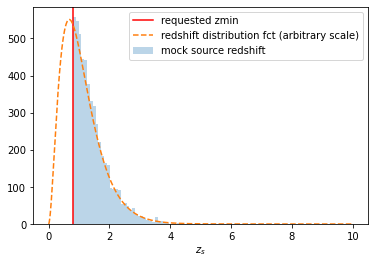

In [11]:
z = np.linspace(0,zsrc_max,1000)

plt.hist(source_catalog['z'], bins=50, alpha=0.3, density=False, label='mock source redshift');
plt.axvline(zsrc_min, color='red', label='requested zmin')
plt.plot(z,zdf(z)*11000, linestyle='dashed',label='redshift distribution fct (arbitrary scale)')
plt.xlabel('$z_s$')
plt.legend()

# 2 - Compute models

In [12]:
#gamma, kappa, gammat, magnification

In [13]:
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec, 
                               cluster_z, source_catalog)

In [14]:
gc_object.compute_tangential_and_cross_components()

(array([0.00276479, 0.00247146, 0.00266583, ..., 0.00284697, 0.00204161,
        0.00202598]),
 array([0.00585274, 0.00286516, 0.00548648, ..., 0.00497303, 0.00482604,
        0.00713834]),
 array([-2.60208521e-18, -1.46367293e-18,  0.00000000e+00, ...,
        -2.16840434e-18, -2.16840434e-18, -3.46944695e-18]))

In [15]:
gc_object.make_radial_profile('Mpc', bins=10, cosmo=cosmo)

radius_min,radius,radius_max,gt,gt_err,gx,gx_err,z,z_err,n_src
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
0.022277313930444933,0.3925378031294943,0.5813815758731443,0.14625102910620263,0.01776503965481086,-5.755937894988104e-17,6.872600131724446e-18,1.5141740925858165,0.06741628011332705,83
0.5813815758731443,0.8926108646913902,1.1404858378158436,0.05467281522238753,0.0016585212669722015,-2.1056657841112806e-17,1.0105994352185721e-18,1.4731005588440151,0.03883768032872202,239
1.1404858378158436,1.4385541475598718,1.699590099758543,0.028100272066780802,0.0005361933290285993,-1.0801027733138269e-17,3.7571488063631633e-19,1.4482868653549528,0.02804645106494246,423
1.699590099758543,2.0042096392726347,2.2586943617012425,0.0176126384956237,0.0002957990591294208,-6.518156021866594e-18,2.0170573269863884e-19,1.4559012386526917,0.024234870739680253,576
2.2586943617012425,2.543080229480899,2.8177986236439416,0.012311694974079712,0.00017065122196560737,-4.3695606305691835e-18,1.2375762045817602e-19,1.4288923306817076,0.019748429241220652,750
2.8177986236439416,3.1090907732380115,3.376902885586641,0.009101932957805235,0.00011507360468778007,-3.382196155329582e-18,8.203610857906096e-20,1.4347282791914584,0.018353298104758595,926
3.376902885586641,3.6669545004664283,3.9360071475293408,0.007135597502104043,8.355031353893887e-05,-2.5797130450540623e-18,5.927484235342652e-20,1.4579369275807448,0.018221161642476544,1073
3.9360071475293408,4.17808623394238,4.49511140947204,0.0060106206021487765,7.893458634966774e-05,-2.2352154581754357e-18,5.897150121396356e-20,1.4971902160936288,0.021787747053562807,762
4.49511140947204,4.742844067405143,5.054215671414739,0.0048719713770236355,9.762173354206167e-05,-1.7406014452476685e-18,7.141279783074683e-20,1.4834072305441928,0.03125858098138769,347


In [17]:
i = 0
gammat_discrete = np.zeros(10)
for i in range(gc_object.profile['radius'].size):
    gammat_discrete[i] = np.mean(clmm.theory.compute_tangential_shear(gc_object.profile['radius'][i], cluster_m, concentration, cluster_z, 
                                            source_catalog['z'], cosmo, delta_mdef=500,  massdef='critical', z_src_info='discrete'))
    
gammat_distribution = clmm.theory.compute_tangential_shear(gc_object.profile['radius'], cluster_m, concentration, cluster_z, 
                                            zdf, cosmo, delta_mdef=500,  massdef='critical', z_src_info='distribution')
    
gammat_beta = clmm.theory.compute_tangential_shear(gc_object.profile['radius'], cluster_m, concentration, cluster_z, 
                                            [beta_s_mean, beta_s_square_mean], cosmo, delta_mdef=500,  massdef='critical', z_src_info='beta')

In [18]:
i = 0
kappa_discrete = np.zeros(10)
for i in range(gc_object.profile['radius'].size):
    kappa_discrete[i] = np.mean(clmm.theory.compute_convergence(gc_object.profile['radius'][i], cluster_m, concentration, cluster_z, 
                                            source_catalog['z'], cosmo, delta_mdef=500,  massdef='critical', z_src_info='discrete'))
    
kappa_distribution = clmm.theory.compute_convergence(gc_object.profile['radius'], cluster_m, concentration, cluster_z, 
                                            zdf, cosmo, delta_mdef=500,  massdef='critical', z_src_info='distribution')
    
kappa_beta = clmm.theory.compute_convergence(gc_object.profile['radius'], cluster_m, concentration, cluster_z, 
                                            [beta_s_mean, beta_s_square_mean], cosmo, delta_mdef=500,  massdef='critical', z_src_info='beta')

In [19]:
i = 0
gt_discrete = np.zeros(10)
for i in range(gc_object.profile['radius'].size):
    gt_discrete[i] = np.mean(clmm.theory.compute_reduced_tangential_shear(gc_object.profile['radius'][i], cluster_m, concentration, cluster_z, 
                                            source_catalog['z'], cosmo, delta_mdef=500,  massdef='critical', z_src_info='discrete', approx=None))
    
gt_distribution = clmm.theory.compute_reduced_tangential_shear(gc_object.profile['radius'], cluster_m, concentration, cluster_z, 
                                            zdf, cosmo, delta_mdef=500,  massdef='critical', z_src_info='distribution', approx="applegate14")
    
gt_beta = clmm.theory.compute_reduced_tangential_shear(gc_object.profile['radius'], cluster_m, concentration, cluster_z, 
                                            [beta_s_mean, beta_s_square_mean], cosmo, delta_mdef=500,  massdef='critical', z_src_info='beta', approx="applegate14")

In [20]:
i = 0
mu_discrete = np.zeros(10)
for i in range(gc_object.profile['radius'].size):
    mu_discrete[i] = np.mean(clmm.theory.compute_magnification(gc_object.profile['radius'][i], cluster_m, concentration, cluster_z, 
                                            source_catalog['z'], cosmo, delta_mdef=500,  massdef='critical', z_src_info='discrete'))
    
mu_distribution = clmm.theory.compute_magnification(gc_object.profile['radius'], cluster_m, concentration, cluster_z, 
                                            zdf, cosmo, delta_mdef=500,  massdef='critical', z_src_info='distribution', approx="weak lensing")
    
mu_beta = clmm.theory.compute_magnification(gc_object.profile['radius'], cluster_m, concentration, cluster_z, 
                                            [beta_s_mean, beta_s_square_mean], cosmo, delta_mdef=500,  massdef='critical', z_src_info='beta',  approx="weak lensing")

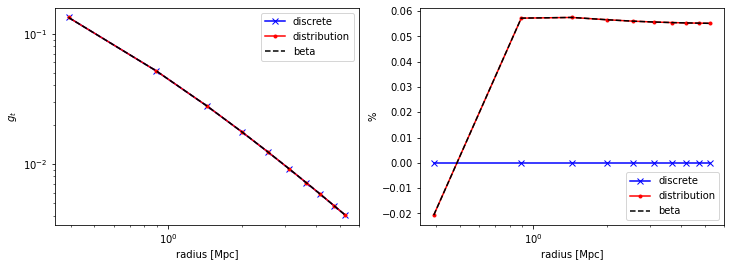

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4),sharex=True)

ax1.loglog(gc_object.profile['radius'], gt_discrete, 'bx-', label = 'discrete')
ax1.loglog(gc_object.profile['radius'], gt_distribution, 'r.-', label = 'distribution')
ax1.loglog(gc_object.profile['radius'], gt_beta, 'k--', label = 'beta')

ax1.set_ylabel('$g_t$')
ax1.set_xlabel('radius [Mpc]')

ax1.legend()

ax2.plot(gc_object.profile['radius'], 100*(gt_discrete-gt_discrete)/gt_discrete, 'bx-', label = 'discrete')
ax2.plot(gc_object.profile['radius'], 100*(gt_distribution-gt_discrete)/gt_discrete, 'r.-', label = 'distribution')
ax2.plot(gc_object.profile['radius'], 100*(gt_beta-gt_discrete)/gt_discrete, 'k--', label = 'beta')

ax2.set_ylabel('%')
ax2.set_xlabel('radius [Mpc]')

ax2.legend()

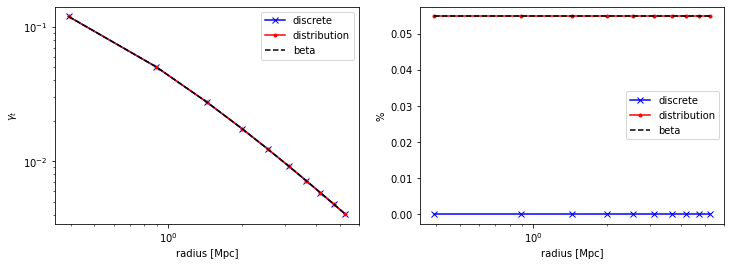

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4),sharex=True)

ax1.loglog(gc_object.profile['radius'], gammat_discrete, 'bx-', label = 'discrete')
ax1.loglog(gc_object.profile['radius'], gammat_distribution, 'r.-', label = 'distribution')
ax1.loglog(gc_object.profile['radius'], gammat_beta, 'k--', label = 'beta')

ax1.set_ylabel('$\\gamma_t$')
ax1.set_xlabel('radius [Mpc]')

ax1.legend()

ax2.plot(gc_object.profile['radius'], 100*(gammat_discrete-gammat_discrete)/gammat_discrete, 'bx-', label = 'discrete')
ax2.plot(gc_object.profile['radius'], 100*(gammat_distribution-gammat_discrete)/gammat_discrete, 'r.-', label = 'distribution')
ax2.plot(gc_object.profile['radius'], 100*(gammat_beta-gammat_discrete)/gammat_discrete, 'k--', label = 'beta')

#ax2.plot(gc_object.profile['radius'], 100*(gammat_distribution-gammat_beta)/gammat_beta, 'r.-', label = 'distribution')
#ax2.plot(gc_object.profile['radius'], 100*(gammat_beta-gammat_beta)/gammat_beta, 'k--', label = 'beta')

ax2.set_ylabel('%')
ax2.set_xlabel('radius [Mpc]')

ax2.legend()

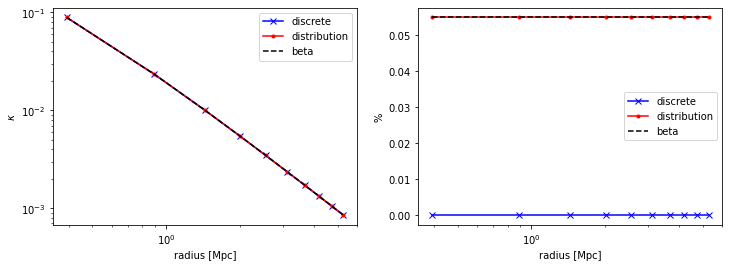

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4),sharex=True)

ax1.loglog(gc_object.profile['radius'], kappa_discrete, 'bx-', label = 'discrete')
ax1.loglog(gc_object.profile['radius'], kappa_distribution, 'r.-', label = 'distribution')
ax1.loglog(gc_object.profile['radius'], kappa_beta, 'k--', label = 'beta')

ax1.set_ylabel('$\\kappa$')
ax1.set_xlabel('radius [Mpc]')

ax1.legend()

ax2.plot(gc_object.profile['radius'], 100*(kappa_discrete-kappa_discrete)/kappa_discrete, 'bx-', label = 'discrete')
ax2.plot(gc_object.profile['radius'], 100*(kappa_distribution-kappa_discrete)/kappa_discrete, 'r.-', label = 'distribution')
ax2.plot(gc_object.profile['radius'], 100*(kappa_beta-kappa_discrete)/kappa_discrete, 'k--', label = 'beta')


ax2.set_ylabel('%')
ax2.set_xlabel('radius [Mpc]')

ax2.legend()

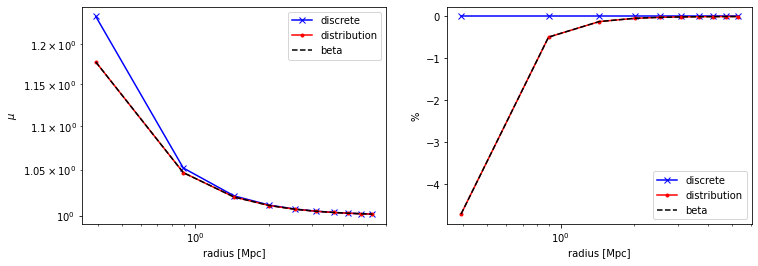

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4),sharex=True)

ax1.loglog(gc_object.profile['radius'], mu_discrete, 'bx-', label = 'discrete')
ax1.loglog(gc_object.profile['radius'], mu_distribution, 'r.-', label = 'distribution')
ax1.loglog(gc_object.profile['radius'], mu_beta, 'k--', label = 'beta')

ax1.set_ylabel('$\\mu$')
ax1.set_xlabel('radius [Mpc]')

ax1.legend()

ax2.plot(gc_object.profile['radius'], 100*(mu_discrete-mu_discrete)/mu_discrete, 'bx-', label = 'discrete')
ax2.plot(gc_object.profile['radius'], 100*(mu_distribution-mu_discrete)/mu_discrete, 'r.-', label = 'distribution')
ax2.plot(gc_object.profile['radius'], 100*(mu_beta-mu_discrete)/mu_discrete, 'k--', label = 'beta')


ax2.set_ylabel('%')
ax2.set_xlabel('radius [Mpc]')

ax2.legend()

### Now that we compared the different approches to describe the same underlying redshift distribution, we will show how we can use the versatility of the functions to answer simple user cases.

#### Case 1 : let's check what signal we expect for a given cluster with LSST source distribution compared to the HST CANDELS field source distribution from Schrabback et al. 2017

In [27]:
gammat_beta_S2017 = clmm.theory.compute_tangential_shear(gc_object.profile['radius'], cluster_m, concentration, cluster_z, 
                                            [cluster_beta_s_mean, cluster_beta_s2_mean], cosmo, delta_mdef=500,  massdef='critical', z_src_info='beta')

gt_beta_S2017 = clmm.theory.compute_reduced_tangential_shear(gc_object.profile['radius'], cluster_m, concentration, cluster_z, 
                                            [cluster_beta_s_mean, cluster_beta_s2_mean], cosmo, delta_mdef=500,  massdef='critical', z_src_info='beta', approx="applegate14")


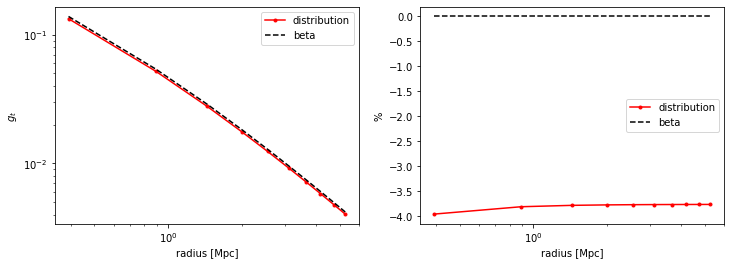

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4),sharex=True)

ax1.loglog(gc_object.profile['radius'], gt_distribution, 'r.-', label = 'distribution')
ax1.loglog(gc_object.profile['radius'], gt_beta_S2017, 'k--', label = 'beta')

ax1.set_ylabel('$g_t$')
ax1.set_xlabel('radius [Mpc]')

ax1.legend()

ax2.plot(gc_object.profile['radius'], 100*(gt_distribution-gt_beta_S2017)/gt_beta_S2017, 'r.-', label = 'distribution')
ax2.plot(gc_object.profile['radius'], 100*(gt_beta_S2017-gt_beta_S2017)/gt_beta_S2017, 'k--', label = 'beta')

ax2.set_ylabel('%')
ax2.set_xlabel('radius [Mpc]')

ax2.legend()

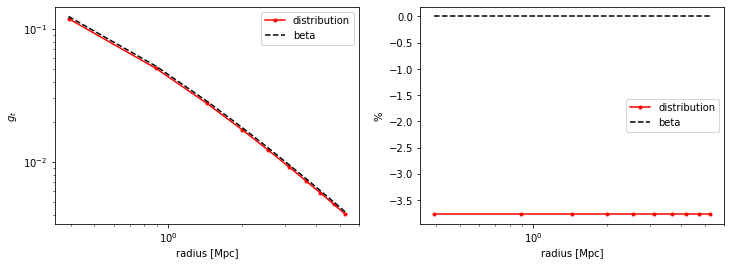

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4),sharex=True)

ax1.loglog(gc_object.profile['radius'], gammat_distribution, 'r.-', label = 'distribution')
ax1.loglog(gc_object.profile['radius'], gammat_beta_S2017, 'k--', label = 'beta')

ax1.set_ylabel('$g_t$')
ax1.set_xlabel('radius [Mpc]')

ax1.legend()

ax2.plot(gc_object.profile['radius'], 100*(gammat_distribution-gammat_beta_S2017)/gammat_beta_S2017, 'r.-', label = 'distribution')
ax2.plot(gc_object.profile['radius'], 100*(gammat_beta_S2017-gammat_beta_S2017)/gammat_beta_S2017, 'k--', label = 'beta')

ax2.set_ylabel('%')
ax2.set_xlabel('radius [Mpc]')

ax2.legend()

#### Case 2 : We want to check what we gain in term of SNR (only accounting for shot noise) when going from LSST Y1 to LSST Y10 source redshift distributions.

In [35]:
#SHEAR LSST__________________________________________________________________
# fiducial number for Y10 (Y1) after blending + masking https://arxiv.org/pdf/1305.0793.pdf
s_e = 0.26
n_e_Y10 = 26 #/u.arcmin**2
n_e_Y1 = 9 #/u.arcmin**2

zdf_Chang2017 = z_distrib_model_p(model="Chang_et_al_2013")

In [44]:
def noise_shear(Ngal,s_e):
    return s_e / np.sqrt(Ngal)

def SNR_shear(shear, Ngal,s_e):
    SNR_s = shear / noise_shear(Ngal,s_e)
    return SNR_s

In [45]:
gammat_distribution_Y = clmm.theory.compute_tangential_shear(gc_object.profile['radius'], cluster_m, concentration, cluster_z, 
                                            zdf_Chang2017, cosmo, delta_mdef=500,  massdef='critical', z_src_info='distribution')

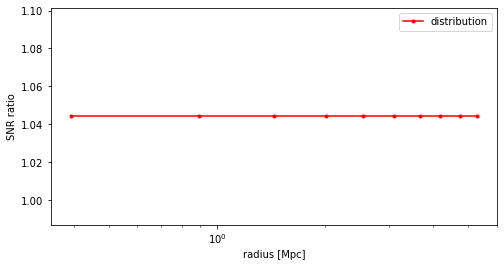

In [47]:
fig, (ax1) = plt.subplots(1,1, figsize=(8,4),sharex=True)

ax1.semilogx(gc_object.profile['radius'], SNR_shear(gammat_distribution_Y,n_e_Y10,s_e)/SNR_shear(gammat_distribution,n_e_Y10,s_e), 'r.-', label = 'distribution')

ax1.set_ylabel('SNR ratio')
ax1.set_xlabel('radius [Mpc]')

ax1.legend()
